In [63]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
%matplotlib inline

In [65]:
from alpenglow.evaluation import DcgScore

In [66]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

In [67]:
import sys
from datawand.parametrization import ParamHelper
ph = ParamHelper('..', 'LinkPrediction', sys.argv)

['/home/fberes/miniconda3/envs/dm-3-env/lib/python3.7/site-packages/ipykernel_launcher.py', '-f', '/home/fberes/.local/share/jupyter/runtime/kernel-59b342c2-77f7-4513-9b54-d871885b2d79.json']
/home/fberes/git_hulk2/LNDynamicTopology
/home/fberes/git_hulk2/LNDynamicTopology
Default parameters:
{'dim': 10, 'ex_known': True, 'neg_rate': 100, 'seed': 254938879, 'top_first_days': 20, 'topk': 20}
Custom parameters:
{}


In [68]:
links_df = pd.read_csv("/mnt/idms/fberes/data/bitcoin_ln_research/link_prediction/data/links_df_20.csv")

In [69]:
links_df.head()

,src,trg,capacity,user,item,time,eval
0,02d97e94cfeedca2a3da47acb400bc6836e671b3cb3fc0...,03fab7f8655169ea77d9691d4bd359e97782cb6177a6f7...,50000,1657,1243,1521522116,0
1,03fab7f8655169ea77d9691d4bd359e97782cb6177a6f7...,02d97e94cfeedca2a3da47acb400bc6836e671b3cb3fc0...,50000,1243,1657,1521522116,0
2,0264089bc3a4afde671b87740d72e03d899b7f0783fbb7...,0312729bfe8c02a1189a94bf609be3f44e7e30f581ada3...,57036,691,1331,1521582953,0
3,0312729bfe8c02a1189a94bf609be3f44e7e30f581ada3...,0264089bc3a4afde671b87740d72e03d899b7f0783fbb7...,57036,1331,691,1521582953,0
4,0246dae073f563308943c44f4d072f226f4968ea6a5a82...,032c4b954f0f171b694b5e8e8323589e54196b48cf2efc...,500000,333,1197,1521810524,0


# Parameters

In [70]:
K = 20#None#30#ph.get("top_first_days")
top_k = 500#100

In [71]:
if K == None:
    delta_t = 86400*7
else:
    delta_t = 86400#

In [72]:
models = [
    "onmf_dim10_lr0.140_nr100",
    #"bomf_dim10_lr0.140_nr100",
    #"offmf_dim10_lr0.050_nr100",
    "pop",
    "time_pop"
]

# Rankings

In [73]:
ranking_dir = "/mnt/idms/fberes/data/bitcoin_ln_research/link_prediction/rankings/topk%i_exkTrue_%s/" % (top_k,str(K))

In [74]:
rankings = [pd.read_csv("%s/%s.csv" % (ranking_dir,m)) for m in models]

In [75]:
[len(df) for df in rankings]

[28323, 28323, 28323]

In [76]:
rankings[0]['time'].min()

1522934222.0

In [77]:
START_TIME = 1548982800 # (GMT): Friday, February 1, 2019 1:00:00 AM

In [78]:
def get_timeframe(df, delta_t, min_time=1548982800):
    df["timeframe"] = df["time"].apply(lambda x: max(0,(x-min_time)//delta_t))

for i in range(len(rankings)):
    get_timeframe(rankings[i], delta_t)

# Results

### a.) average performance (online DCG)

The average performance for the offline batch model is confusing (it is only bad on the first day)

In [79]:
def show_mean_dcg(with_first_day=True):
    if with_first_day:
        mean_dcgs = [df["dcg"].mean() for df in rankings]
        df = rankings[0]
        print(len(df))
    else:
        mean_dcgs = [df[df["timeframe"]>0]["dcg"].mean() for df in rankings]
        df = rankings[0]
        print(len(df[df["timeframe"]>0]))
    return pd.DataFrame(list(zip(models, mean_dcgs)), columns=["model","dcg"]).sort_values("dcg", ascending=False).reset_index(drop=True)

#### Global mean performance

In [80]:
show_mean_dcg(True)

28323


,model,dcg
0,onmf_dim10_lr0.140_nr100,0.238265
1,time_pop,0.203287
2,pop,0.174952


#### Mean performance without first day

In [81]:
show_mean_dcg(False)

10038


,model,dcg
0,onmf_dim10_lr0.140_nr100,0.237509
1,time_pop,0.208349
2,pop,0.150523


**Exclude known: False**
0 	online 	0.139660
1 	batch+online 	0.131745
2 	pop+time 	0.124183
3 	pop 	0.077110
4 	batch 	0.064587

**Exclude known: True - Miért teljesen uaz?**
0 	online 	0.139660
1 	batch+online 	0.131745
2 	pop+time 	0.124183
3 	pop 	0.077110
4 	batch 	0.064587

### b.) Performance over time

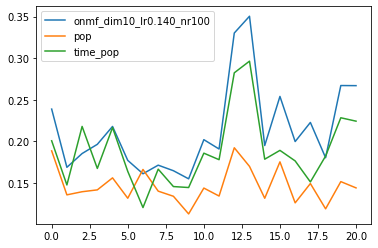

In [82]:
for idx, ranking in enumerate(rankings):
    averages = ranking.groupby("timeframe")["dcg"].mean()
    plt.plot(averages, label=models[idx])
plt.legend()

### c.) Number of records over time

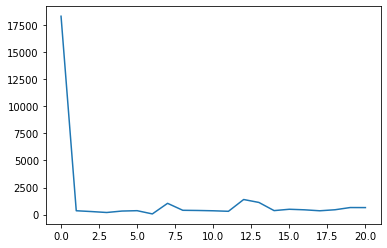

In [83]:
cnt = rankings[0].groupby("timeframe")["dcg"].count()
plt.plot(cnt)

# Simulation based results

link_sim_cols = ["opt_income","global_traffic","global_income","inbound_depletions","high_degree","high_cap"]

In [84]:
link_sim_cols = ["global_traffic","global_income","inbound_depletions","high_degree","high_cap"]

In [85]:
def load_link_sim_experiment(model_dir):
    model_id = model_dir.split("/")[-2]
    print(model_id)
    model_files = os.listdir(model_dir)
    chunks = [pd.read_csv("%s/%s" % (model_dir, f)) for f in model_files if "snapshot" in f]
    concatenated = pd.concat(chunks)
    print(len(model_files), len(concatenated))
    get_timeframe(concatenated, delta_t)
    for rank_col in link_sim_cols:
        print(rank_col)
        concatenated["dcg_"+rank_col] = DcgScore(concatenated.rename({rank_col:"rank"}, axis=1))
        print(concatenated["dcg_"+rank_col].mean())
    return concatenated

### Load simulation results

In [120]:
#experiments = ["50000sat_k6000_aNone_e0.05_dropTrue"]
#experiments = ["60000sat_k7000_e0.80"]
#experiments = ["60000sat_k7000_e0.80_otTrue"]
experiments = ["60000sat_k1000_e0.80_ddTrue_dlcTrue_wdTrue_twNone_otFalse"]
experiments = ["60000sat_k14000_e0.80_ddTrue_dlcTrue_wdTrue_twNone_otFalse"]
experiments = ["200000sat_k7000_e0.80_ddTrue_dlcTrue_wdTrue_twNone_otFalse"]
experiments = ["60000sat_k7000_e0.00_ddTrue_dlcTrue_wdTrue_twNone_otFalse"]
experiments = ["60000sat_k7000_e0.80_ddFalse_dlcTrue_wdTrue_twNone_otFalse"]
experiments = ["60000sat_k7000_e0.80_ddTrue_dlcTrue_wdFalse_twNone_otFalse"]
experiments = ["60000sat_k7000_e0.80_ddTrue_dlcFalse_wdFalse_twNone_otFalse"]
experiments = ["60000sat_k7000_e0.80_ddFalse_dlcFalse_wdFalse_twNone_otFalse"]
experiments = ["60000sat_k7000_e0.80_ddFalse_dlcTrue_wdTrue_tw86400_otFalse"]
experiments = ["60000sat_k7000_e0.80_ddFalse_dlcTrue_wdTrue_tw604800_otFalse"]
experiments = ["60000sat_k7000_e0.80_ddFalse_dlcTrue_wdTrue_tw1209600_otFalse"]
experiments = ["200000sat_k7000_e0.80_ddFalse_dlcTrue_wdTrue_tw86400_otFalse"]
experiments = ["200000sat_k7000_e0.00_ddFalse_dlcTrue_wdTrue_tw86400_otFalse"]

#experiments = ["200000sat_k14000_e0.80_ddTrue_dlcTrue_wdTrue_twNone_otFalse"]
#experiments = ["200000sat_k70000_e0.80_ddTrue_dlcTrue_wdTrue_twNone_otFalse"]
#experiments = ["200000sat_k14000_e0.80_ddTrue_dlcTrue_wdTrue_tw604800_otFalse"]
#experiments = ["200000sat_k70000_e0.80_ddTrue_dlcTrue_wdTrue_tw604800_otFalse"]
experiments = ["500000sat_k14000_e0.80_ddTrue_dlcTrue_wdTrue_twNone_otFalse"]
experiments = ["500000sat_k70000_e0.80_ddTrue_dlcTrue_wdTrue_twNone_otFalse"]
experiments = ["500000sat_k14000_e0.80_ddTrue_dlcTrue_wdTrue_tw604800_otFalse"]
experiments = ["500000sat_k70000_e0.80_ddTrue_dlcTrue_wdTrue_tw604800_otFalse"]

#experiments = ["500000sat_k70000_e0.80_ddTrue_dlcTrue_wdTrue_twNone_otFalse_hl86400"]
experiments = ["500000sat_k70000_e0.80_ddTrue_dlcTrue_wdTrue_twNone_otFalse_hl604800"]

experiments = ["1000000sat_k70000_e0.80_ddTrue_dlcTrue_wdTrue_twNone_otFalse_hlNone"]
experiments = ["1000000sat_k70000_e0.80_ddTrue_dlcTrue_wdTrue_twNone_otFalse_hl3600"]

experiments = ["1000000sat_k700000_e0.80_ddTrue_dlcTrue_wdTrue_twNone_otFalse_hlNone"]

In [121]:
simulation_results = [load_link_sim_experiment("%s/%s/" % (ranking_dir, experiment_id)) for experiment_id in experiments]

1000000sat_k700000_e0.80_ddTrue_dlcTrue_wdTrue_twNone_otFalse_hlNone
60 4122
global_traffic
0.11379564160175441
global_income
0.10806617315120585
inbound_depletions
0.10876446593955479
high_degree
0.1323229237497886
high_cap
0.11470165749422397


### Join all simulation experiments into one dataframe

In [26]:
sim_preds = simulation_results[0]

In [27]:
for idx, model in enumerate(experiments[1:]):
    print(model)
    sim_preds = sim_preds.merge(simulation_results[idx+1][["record_id",model]], on="record_id", how="left")

In [28]:
sim_preds.head()

,record_id,src,trg,time,capacity,eval,snapshot,global_traffic,global_income,inbound_depletions,high_degree,high_cap,timeframe,dcg_global_traffic,dcg_global_income,dcg_inbound_depletions,dcg_high_degree,dcg_high_cap
0,54864,0232e20e7b68b9b673fb25f48322b151a93186bffe4550...,02df2cefe673216c26caaa28cc72e0f616242e5b06b0f0...,1549935931,300000,1,9,313.0,311.0,232.0,NaN,NaN,11,0.120560,0.120694,0.127159,0.000000,0.000000
1,54868,022adae0a54a0e1fbe0f34c81b363506f5bb9c43e31e4f...,026c68891151fd5409a84eeed017c8cefadcff00158f76...,1549936540,96745,1,9,NaN,NaN,NaN,NaN,NaN,11,0.000000,0.000000,0.000000,0.000000,0.000000
2,54872,02eea148af01585bf2b596577352d48841f0dd825d9f0d...,0279c22ed7a068d10dc1a38ae66d2d6461e269226c6025...,1549937089,5000001,1,9,88.0,3.0,NaN,4.0,5.0,11,0.154423,0.500000,0.000000,0.430677,0.386853
3,54876,021fdb1d2ae9ac1b7b8f0868b92d4a46bdfa4e386dd69a...,0217890e3aad8d35bc054f43acc00084b25229ecff0ab6...,1549937289,367411,1,9,3.0,13.0,NaN,5.0,43.0,11,0.500000,0.262650,0.000000,0.386853,0.183169
4,54880,0331f80652fb840239df8dc99205792bba2e559a054699...,03c75f96bad4a1a5fe687574a20b2a8b3f9f2a45d63b92...,1549937445,5000000,1,9,375.0,373.0,296.0,369.0,NaN,11,0.116896,0.117002,0.121739,0.117214,0.000000


### Joining baselines with simulation results

In [29]:
for idx, model in enumerate(models):
    sim_preds = sim_preds.merge(rankings[idx][["id","dcg"]].rename({"id":"record_id","dcg":model}, axis=1), on="record_id", how="left")

sim_preds[experiments+models].mean().sort_values(ascending=False)

In [30]:
sim_preds[models+ ["dcg_global_traffic","dcg_global_income","dcg_inbound_depletions","dcg_high_degree","dcg_high_cap"]].mean().sort_values(ascending=False)

onmf_dim10_lr0.140_nr100    0.237172
time_pop                    0.208200
pop                         0.150576
dcg_high_cap                0.145786
dcg_high_degree             0.145113
dcg_global_income           0.106805
dcg_global_traffic          0.095680
dcg_inbound_depletions      0.057967
dtype: float64

# Rank combination

In [ ]:
onmf_preds = pd.read_csv("%s/preds_onmf_dim10_lr0.140_nr100.csv" % ranking_dir)
onmf_preds = onmf_preds.drop("dcg", axis=1)
onmf_preds.shape

In [ ]:
tpop_preds = pd.read_csv("%s/preds_time_pop.csv" % ranking_dir)
tpop_preds = tpop_preds.drop("dcg", axis=1)
tpop_preds.shape

In [ ]:
sim_model_preds = {}

In [ ]:
sim_model = experiments[0]
for m in link_sim_cols:
    tmp_parts = [pd.read_csv("%s/%s/preds_%s_%i.csv" % (ranking_dir,sim_model,m,i)) for i in range(19)]
    tmp = pd.concat(tmp_parts, ignore_index=True)
    sim_model_preds[m] = tmp
    print(m)

### filter for common records

common_record_ids = set(onmf_preds["record_id"])
len(common_record_ids)

In [ ]:
common_record_ids = set(sim_model_preds["global_income"]["record_id"])
len(common_record_ids)

In [ ]:
for m in link_sim_cols:
    tmp = sim_model_preds[m]
    sim_model_preds[m] = tmp[tmp["record_id"].isin(common_record_ids)]
    print(m, sim_model_preds[m].shape)
onmf_preds = onmf_preds[onmf_preds["record_id"].isin(common_record_ids)]
print("onmf", onmf_preds.shape)
tpop_preds = tpop_preds[tpop_preds["record_id"].isin(common_record_ids)]
print("tpop", tpop_preds.shape)

### extract real targets

In [ ]:
real_targets = dict(links_df.loc[common_record_ids]["item"])

In [ ]:
len(real_targets)

### recoding keys to ids

In [ ]:
node_2_id = dict(zip(links_df["src"],links_df["user"]))
node_2_id.update(dict(zip(links_df["trg"],links_df["item"])))

In [ ]:
id_2_node = dict(zip(links_df["user"],links_df["src"]))
id_2_node.update(dict(zip(links_df["item"],links_df["trg"])))

In [ ]:
for m in link_sim_cols:
    tmp = sim_model_preds[m]
    tmp["user"] = tmp["user"].apply(lambda x: node_2_id[x])
    tmp["item"] = tmp["item"].apply(lambda x: node_2_id[x])
    sim_model_preds[m] = tmp
    print(m)

In [ ]:
sim_model_preds["onmf"] = onmf_preds
sim_model_preds["tpop"] = tpop_preds

# Prediction insights?

In [ ]:
node_names = pd.read_csv("/mnt/idms/fberes/data/bitcoin_ln_research/node_names.csv")

In [ ]:
tmp = sim_model_preds["onmf"].copy()

In [ ]:
tmp = sim_model_preds["tpop"].copy()

In [ ]:
tmp["src"] = tmp["user"].apply(lambda x: id_2_node[x])
tmp["trg"] = tmp["item"].apply(lambda x: id_2_node[x])

In [ ]:
tmp = tmp.merge(node_names, left_on="trg", right_on="pub_key", how="left").drop("pub_key", axis=1)

tmp.head()

In [ ]:
tmp.groupby("name")["rank"].mean().sort_values().head(30)

In [ ]:
tmp.groupby("name")["score"].sum().sort_values(ascending=False).head(50)

tmp_2 = sim_model_preds["global_traffic"].copy()

In [ ]:
tmp_2 = sim_model_preds["high_degree"].copy()

In [ ]:
tmp_2["src"] = tmp_2["user"].apply(lambda x: id_2_node[x])
tmp_2["trg"] = tmp_2["item"].apply(lambda x: id_2_node[x])

In [ ]:
tmp_2 = tmp_2.merge(node_names, left_on="trg", right_on="pub_key", how="left").drop("pub_key", axis=1)

tmp_2.head()

In [ ]:
tmp_2.groupby("name")["rank"].mean().sort_values().head(10)

tmp_2.groupby("trg")["score"].sum().sort_values(ascending=False).head(10)

### combination

In [ ]:
import numpy as np
import functools
import concurrent.futures

def performance(pred_df,real_targets):
    """real_targets contains true items for only the related sessions"""
    df = pred_df.copy()
    df.loc[:,"true_item"] = df["record_id"].apply(lambda x: real_targets[x])
    hits = df[df["true_item"]==df["item"]]
    hits.loc[:,"dcg"] = 1.0 / (np.log2(hits["rank"]+1.0))
    return hits["rec_rank"].sum() / len(real_targets), hits["dcg"].sum() / len(real_targets)

def extract_topk(df, key_col, score_col, k):
    groups = dict(tuple(df.groupby(key_col)))
    topk_parts = [groups[key].nlargest(k,score_col) for key in groups]
    return pd.concat(topk_parts, ignore_index=True)

def combine_ranks(preds_1, preds_2, k, alpha, trim=True):
    cols = ["record_id","item","rec_rank"]
    p1 = preds_1[cols].copy()
    p2 = preds_2[cols].copy()
    p1.loc[:,"rec_rank"] = p1["rec_rank"]*alpha
    p2.loc[:,"rec_rank"] = p2["rec_rank"]*(1.0-alpha)
    combined = pd.concat([p1,p2], ignore_index=True)
    combined = combined.groupby(["record_id","item"])["rec_rank"].sum().reset_index()
    combined = combined[combined["rec_rank"]>0]
    combined.loc[:,"rank"] = 1.0 / combined["rec_rank"]
    combined.loc[:,"dcg"] = DcgScore(combined)
    if trim:
        old_size = len(combined)
        combined = extract_topk(combined, "record_id", "rec_rank", k)
        print(alpha,len(p1),len(combined),old_size/len(p1))
    return combined

def combine_and_eval(model1, model2, true_targets, k, a):
    combi = combine_ranks(model1, model2, k, a)
    mrr, mdcg = performance(combi, true_targets)
    #print(len(combi)/len(model2))
    return mrr, mdcg

def combine_models(model1, model2, true_targets, alphas, filter_m1=False, max_threads=4):
    if filter_m1:
        m1 = model1[model1["prediction"]>0]
        print("filter",len(model1),len(m1))
    else:
        m1 = model1
    f_partial = functools.partial(combine_and_eval, m1, model2, true_targets, top_k)
    executor = concurrent.futures.ProcessPoolExecutor(max_threads)
    res = list(executor.map(f_partial, alphas))
    executor.shutdown()
    mrrs, mdcgs = zip(*res)
    #print(mrrs)
    print(mdcgs)
    #plt.figure()
    #plt.plot(alphas,mrrs,'bx',label="mrr")
    #plt.plot(alphas,mdcgs,'rx',label="mdcg")
    #plt.legend()

In [ ]:
for col in sim_model_preds:
    tmp = sim_model_preds[col]
    tmp["rec_rank"] = 1.0 / tmp["rank"]
    sim_model_preds[col] = tmp
    print(col)

#### double check: single model performance

In [ ]:
for col in sim_model_preds:
    print(col, performance(sim_model_preds[col], real_targets))

In [ ]:
#alphas = np.arange(0,1.1,0.1)# 0.075 is best: 0.239715
alphas = [0.0,0.001,0.002,0.005,0.01,0.02,0.03,0.1,1.0]
#alphas = [0.0,0.01,0.02,0.03,0.04,0.05,0.1,0.2,0.5,1.0]
#alphas = [0.0,0.025,0.05,0.075,0.1,0.15,0.2,1.0]

#### NOTE: finally for topk=500 models can combine!

In [ ]:
combine_models(tpop_preds, onmf_preds, real_targets, alphas, max_threads=len(alphas))

for col in link_sim_cols:
    print("###%s###" % col)
    combine_models(sim_model_preds[col], onmf_preds, real_targets, alphas, filter_m1=False, max_threads=len(alphas))
    print()

In [ ]:
for col in link_sim_cols:
    print("###%s###" % col)
    combine_models(sim_model_preds[col], onmf_preds, real_targets, alphas, filter_m1=True, max_threads=len(alphas))
    print()

combine_models(only_sim_preds, onmf_preds, alphas)

# Betweeness baseline

from link_pred_simulator import load_graph_snapshots, process_links_for_simulator

snapshots, time_boundaries = load_graph_snapshots("/mnt/idms/fberes/data/bitcoin_ln_research/directed_graphs/directed_temporal_multi_edges_1days.csv")

links_for_sim = process_links_for_simulator(links_df, None, time_boundaries, only_eval=False, verbose=True)

links_for_sim["eval"].value_counts()

from tqdm import tqdm

def calculate_rank(scores_df, true_target, top_k, seen_nodes=None):
        # scores_df is preordered
        if seen_nodes == None:
            ordered_list = list(scores_df["index"])[:top_k]
        else:
            ordered_list = list(scores_df[~scores_df["index"].isin(seen_nodes)]["index"])[:top_k]
        return ordered_list.index(true_target)+1.0 if true_target in ordered_list else None

def extract_central_nodes(file_path, metric):
    scores_df = pd.read_csv(file_path, usecols=["index","betw"])
    return scores_df.sort_values(metric, ascending=False)[["index",metric]]
    
class BetweenessModel():
    def __init__(self, centrality_dir="/mnt/idms/fberes/data/bitcoin_ln_research/centrality_scores", weight=None):
        self.metric = "betw"
        self.weight = weight
        self.centrality_dir = centrality_dir
        self.top_k_preds = {}
        
    def run(self, links, k, exclude_known=True):
        self.graph = {}
        max_snap_id = links["snapshot"].max()
        for snap_id in range(max_snap_id+1):
            f_path = "%s/scores_%s_%i.csv" % (self.centrality_dir, self.weight, snap_id)
            self.top_k_preds[snap_id] = extract_central_nodes(f_path, self.metric)
        ranks = []
        indices = links.index
        for idx in tqdm(indices):
            row = links.loc[idx]
            snap_id, src, trg, eval_ = row["snapshot"], row["src"], row["trg"], row["eval"]
            if not src in self.graph:
                self.graph[src] = set()
            if eval_:
                seen_nodes = self.graph[src] if exclude_known else None
                ranks.append(calculate_rank(self.top_k_preds[snap_id], trg, k, seen_nodes))
            else:
                ranks.append(None)
            self.graph[src].add(trg)
        rankings = links.copy()
        rankings["rank"] = ranks
        return rankings[rankings["eval"]==1]

# How can it be the same DCG???

bm = BetweenessModel()

bm_rankings = bm.run(links_for_sim, 20, exclude_known=True)

bm_rankings["dcg"] = DcgScore(bm_rankings)

bm_rankings["dcg"].mean()

bm_rankings_f = bm.run(links_for_sim, 20, exclude_known=False)

bm_rankings["dcg"] = DcgScore(bm_rankings)

bm_rankings["dcg"].mean()

# Join

In [ ]:
d1 = pd.read_csv("/mnt/idms/fberes/data/bitcoin_ln_research/link_prediction/data/channel_events_20.csv")

In [ ]:
d2 = pd.read_csv("../DynamicNetworkAnalysis/ln.tsv", sep="\t", header=None)

In [ ]:
d1.head()

In [ ]:
d1.dtypes

In [ ]:
d2.tail()

In [ ]:
d2.dtypes

In [ ]:
int("562210x2014x0")

In [ ]:
d2[0].apply(lambdabda x: long(x))